### Extract outcome variables from excel sheret

In [1]:
import pandas as pd
import json
import os
from pathlib import Path

In [29]:
# Load the CSV file
conf_name = "2021ABI"
csv_file_path = f"/Users/eveyhuang/Documents/NICO/gemini_code/data/{conf_name}/ABI_teams_2021.xlsx"
df = pd.read_excel(csv_file_path)

# Process the data
teams_data = []
for index, row in df.iterrows():
    team_id = row['team_id']
    funded_status = 1 if row['funding_status'] == 'funded' else 0
    team_members = row['team_members'].split(', ')
    
    team_info = {
        "team_id": team_id,
        "funded_status": funded_status,
        "members": team_members
    }
    teams_data.append(team_info)

output_file_path = f'/Users/eveyhuang/Documents/NICO/gemini_code/data/{conf_name}/{conf_name}_outcome.json'

# Save the teams_data to a JSON file
with open(output_file_path, 'w') as json_file:
    json.dump(teams_data, json_file, indent=4)

# Output the result
print(teams_data)

[{'team_id': 'ABI1', 'funded_status': 0, 'members': ['Qian Liu', 'Anna-Karin Gustavsson']}, {'team_id': 'ABI2', 'funded_status': 1, 'members': ['Douglas Shepherd', 'Shannon Quinn', 'Domenico (Nick) Galati']}, {'team_id': 'ABI3', 'funded_status': 0, 'members': ['Alexandra Dickinson', 'Barbara Smith']}, {'team_id': 'ABI4', 'funded_status': 0, 'members': ['Shwetadwip Chowdhury', 'Candace Fleischer']}, {'team_id': 'ABI5', 'funded_status': 1, 'members': ['Aseema Mohanty', 'Srigokul Upadhyayula']}, {'team_id': 'ABI6', 'funded_status': 1, 'members': ['Allison Dennis', 'Carolyn Bayer']}, {'team_id': 'ABI7', 'funded_status': 0, 'members': ['Dylan Burnette', 'Ulugbek Kamilov', 'Mark Sellmyer']}, {'team_id': 'ABI8', 'funded_status': 0, 'members': ['Morteza Mahmoudi', 'Lingyan Shi', 'Shiva Abbaszadeh']}, {'team_id': 'ABI9', 'funded_status': 1, 'members': ['Ulugbek Kamilov', 'Lu Wei', 'Benjamin Bartelle']}, {'team_id': 'ABI10', 'funded_status': 0, 'members': ['Uzay Emir', 'Domenico (Nick) Galati']}

### merge data for each session in output into data folder

In [22]:
import re

def add_times(time1, time2):
    
    # Split the time strings into hours and minutes
    hours1, minutes1 = map(int, time1.split(':'))
    hours2, minutes2 = map(int, time2.split(':'))
    
    # Add the hours and minutes separately
    total_hours = hours1 + hours2
    total_minutes = minutes1 + minutes2
    
    # If total minutes are 60 or more, convert to hours
    if total_minutes >= 60:
        total_hours += total_minutes // 60
        total_minutes = total_minutes % 60
    
    #print(f"adding {time1} and {time2} result is {total_hours:02}:{total_minutes:02}")
    # Format the result as "HH:MM"
    return f"{total_hours:02}:{total_minutes:02}"

def normalize_name(full_string):
    """
    Extracts just the name from various formats of name strings.
    
    Args:
        full_string: String containing name and additional information
        
    Returns:
        String containing just the name
    
    """
    # Remove common titles
    full_string = re.sub(r'^(Dr\.?|Prof\.?|Professor|Mr\.?|Ms\.?|Mrs\.?)\s+', '', full_string, flags=re.IGNORECASE)
    
    # Remove everything after common separators
    for separator in [' (', '-', ',']:
        if separator in full_string:
            full_string = full_string.split(separator)[0]
    
    # Clean up any remaining whitespace
    name = full_string.strip()
    
    name = name.replace('.', '')
    # Handle cases where institution is connected with a hyphen without space
    parts = name.split('-')
    if len(parts) > 1:
        # Check if the part after hyphen contains "University" or similar institutional words
        if any(word in parts[-1].lower() for word in ['university', 'college', 'institute', 'school', 'u of']):
            name = parts[0].strip()
    
    return name

def split_name(name):
    """Split a name into first and last (handles middle names by joining all but last as first)."""
    parts = name.strip().split()
    if len(parts) == 1:
        return parts[0], ""
    return " ".join(parts[:-1]), parts[-1]
from difflib import SequenceMatcher

def find_matching_name(name, correct_names, last_name_threshold=0.9, first_name_threshold=0.3):
    """
    Fuzzy match names, requiring a strong match on last name and a looser match on first name.
    """
    name_first, name_last = split_name(name.lower())
    best_match = None
    best_score = 0

    for correct_name in correct_names:
        correct_first, correct_last = split_name(correct_name.lower())
        # Compare last names
        last_ratio = SequenceMatcher(None, name_last, correct_last).ratio()
        if last_ratio >= last_name_threshold:
            # Compare first names
            first_ratio = SequenceMatcher(None, name_first, correct_first).ratio()
            # Use average or weighted score for ranking
            score = (last_ratio + first_ratio) / 2
            if first_ratio >= first_name_threshold and score > best_score:
                best_score = score
                best_match = correct_name

    if best_match:
        return best_match, best_score
    return None, 0

# Example usage with more complex cases:
def find_and_correct_name(name, correct_names, threshold=0.8):
    """
    Wrapper function that provides more detailed output about name matching.
    
    Args:
        name: String containing the potentially misspelled name
        correct_names: List of correctly spelled names
        threshold: Float between 0 and 1, minimum similarity ratio to consider a match
        
    Returns:
        Dictionary containing matching information
    """
    name = normalize_name(name)
    match, ratio = find_matching_name(name, correct_names, threshold)
    result = {
        "input_name": name,
        "matched_name": match,
        "similarity": round(ratio, 3),
        "is_match": ratio >= threshold
    }
    
    return result

In [70]:
# CHANGE conf name here 
conf_name = '2022MND'

conference_dir = f'data/{conf_name}'
gemini_output_dir = f'outputs/{conf_name}'
output_dir = f'data/{conf_name}'

In [71]:
import os
import json
from collections import defaultdict


with open(f'data/{conf_name}/{conf_name}_outcome.json') as f:
    teams_data = json.load(f)

team_data_names = set()

for team in teams_data:
    members = team['members']
    for name in members:
        team_data_names.add(name)


def normalize_keys(entry):
    normalized = {}
    for key, value in entry.items():
        normalized[key.replace(' ', '_')] = value
    return normalized

def convert_time_to_seconds(time_str):
    """
    Convert time string in format "MM:SS" or "M:SS" to total seconds.
    Also handles numeric strings that are already in seconds.
    """
    if isinstance(time_str, (int, float)):
        return int(time_str)
    
    time_str = str(time_str).strip()
    
    # If it's already a number, return it
    try:
        return int(time_str)
    except ValueError:
        pass
    
    # Handle time format like "3:59" or "03:59"
    if ':' in time_str:
        parts = time_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:
            # Handle HH:MM:SS format
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours * 3600 + minutes * 60 + seconds
    
    # If we can't parse it, return 0
    print(f"Warning: Could not parse time string '{time_str}', using 0 seconds")
    return 0
# merge data from output folders 
def merge_json_files(directory):
    merged_data = []
    all_speakers = []
    speaking_length = 0
    last_end_time = "00:00"
    unmatch_names = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.startswith("all_llama") and file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    for entry in data:
                        entry = normalize_keys(entry)
                        
                        
                        match_name_result = find_and_correct_name(entry['speaker'], team_data_names)
                        if match_name_result['is_match']:
                            entry['speaker'] = match_name_result['matched_name']
                        else:
                            entry['speaker'] = match_name_result['input_name']
                            unmatch_names.add(entry['speaker'])
                        all_speakers.append(entry['speaker'])
                        if type(entry['speaking_duration']) == str:
                            entry['speaking_duration'] = convert_time_to_seconds(entry['speaking_duration'])
                        speaking_length += int(entry['speaking_duration'])
                        entry['start_time'] = add_times(entry['start_time'], last_end_time)
                        entry['end_time'] = add_times(entry['end_time'], last_end_time)
                            
                        merged_data.append(entry)
                    try:    
                        last_end_time = max(entry['end_time'] for entry in data)
                    except ValueError:
                        print(f"Error processing file {file_path}: {data}")
                        continue
                    
    unique_speakers = set(all_speakers)   
    print(f"{directory}, unmatched names: {unmatch_names}")             
    return merged_data, list(unique_speakers), speaking_length



if not os.path.exists(output_dir):
     os.makedirs(output_dir)

for folder in os.listdir(gemini_output_dir):
     if folder.startswith("output"):
          folder_path = os.path.join(gemini_output_dir, folder)
          merged_data, all_speaker, speaking_length = merge_json_files(folder_path)
          
          result = {
                "all_speakers": all_speaker,
                "total_speaking_length": speaking_length,
                "all_data": merged_data,     
          }
          
          output_file_name = folder.replace("output_", "").strip()
          output_file_path = os.path.join(output_dir, f"{output_file_name}.json")
          
          with open(output_file_path, 'w') as f:
                json.dump(result, f, indent=4)


outputs/2022MND/output_2022_04_07_MND_S5, unmatched names: {'Unidentified Speaker', 'Rosa Krajmalnik', 'Tom Mansell', 'Andrew Feig', 'Richard Wiener', 'Melanie Gareau'}
outputs/2022MND/output_2022_04_07_MND_S2, unmatched names: {'Kai Zhang | UIUC', 'Rima kaddurah daouk', 'Mei Shen_University of Illinois at Urbana', 'Heather Bean', 'Barbara Bendlin', 'Heather Bean | ASU', 'Sandra Laney', 'Alexandra Basford'}
outputs/2022MND/output_2022_04_07_MND_S3, unmatched names: {'Chris Whidbey', 'Wenjing Wang', 'JP Yu', 'Ali Keshavarzi', 'Jodi Lilley', 'Irene Yang', 'Andrew Feig', 'Rachel Saylor', 'Richard Wiener', 'Ali Keshavarzian'}
outputs/2022MND/output_2022_04_07_MND_S4, unmatched names: {'Okay', 'Rosa Krajmalnik', 'Tom Mansell', 'Andrew Feig', 'Melanie Gareau'}
outputs/2022MND/output_2022_04_08_MND_S6, unmatched names: {'Mark Mimee', 'George Weinstock'}
outputs/2022MND/output_2022_04_08_MND_S1, unmatched names: {'Heather Bean', 'Irene Yang', 'Silvia Ronco', 'Richard Wiener', 'Melanie Gareau',

In [ ]:
# Read outcome.json to get team information (match each person to their team and funding status)

outcome_file = os.path.join(conference_dir, f'{conf_name}_outcome.json')
with open(outcome_file, 'r') as f:
    outcome_data = json.load(f)

# Create a mapping of normalized full names to their team IDs
name_to_teams = defaultdict(list)  # Changed to defaultdict to store multiple teams per person
for proposal in outcome_data:
    team_id = proposal.get('team_id', '')
    member_names = proposal.get('members', [])
    funded_status = proposal.get('funded_status', None)
    
    if member_names:
        for name in member_names:
            
            name_to_teams[name].append({
                'team_id': team_id,
                'full_name': name,
                'funded_status': funded_status
            })


with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'w') as f:
    data = json.dump(name_to_teams, f, indent=4)

print(data)

None


In [79]:
from collections import defaultdict, OrderedDict

with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'r') as f:
    name_to_teams = json.load(f)
    
all_sessions = OrderedDict()

# Process each JSON file in the directory
for filename in os.listdir(conference_dir):
    if filename.endswith('.json') and filename != f'{conf_name}_outcome.json':
        file_path = os.path.join(conference_dir, filename)
        
        
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
            except:
                print(f"Error loading {filename}")
                continue
        
        if "all_speakers" in data:
            # Create an ordered dictionary for this session
            session_data = OrderedDict()
            session_data["all_speakers"] = list(set(data["all_speakers"]))
            
            # Find teams present in this session
            teams_in_session = defaultdict(list)
            for name in data["all_speakers"]:
                
                if name in name_to_teams:
                    # Add person to all their teams
                    for team_info in name_to_teams[name]:
                        teams_in_session[team_info['team_id']].append({
                            'name': team_info['full_name'],
                            'funded_status': team_info['funded_status'],
                            'team_id': team_info['team_id']
                        })
                
            
            # Add team information to session data, only including teams with at least 2 members
            if teams_in_session:
                session_data["teams"] = OrderedDict()
                for team_id, team_info in teams_in_session.items():
                    if len(team_info) >= 2:  # Only include teams with 2 or more members
                        session_data["teams"][team_id] = {
                            "members": [member['name'] for member in team_info],
                            "funded_status": team_info[0]['funded_status'] if team_info else None
                        }
            
            # Add to the main dictionary using the filename (without .json) as the key
            session_name = os.path.splitext(filename)[0]
            all_sessions[session_name] = session_data
            
            
        else:
            print(f"Skipping {filename} because it doesn't contain 'all_speakers'")


seen_names = set()
for session_data in all_sessions.values():
    if "all_speakers" in session_data:
        seen_names.update(session_data["all_speakers"])

# Step 2: Find unmatched names
unmatched_names = set(name_to_teams.keys()) - seen_names

# Step 3: Print them
print("*** Names in outcome.json not identified in any session (could be due to different spellings or typos):")
for name in unmatched_names:
    print(name)
    
all_sessions['missing_names'] = list(unmatched_names)
# Step 2: Find people not in any team
not_in_any_team = seen_names - set(name_to_teams.keys())

# Step 3: Print them
print("*** People in sessions who never joined any team:")
for name in not_in_any_team:
    print(name)

all_sessions['people_not_in_any_team'] = list(set(not_in_any_team))
with open(f'data/{conf_name}/{conf_name}_session_outcomes.json', 'w') as f:
    data = json.dump(all_sessions, f, indent=4)


Error loading 2022MND_session_outcomes.json
Skipping 2022MND_person_to_team.json because it doesn't contain 'all_speakers'
*** Names in outcome.json not identified in any session (could be due to different spellings or typos):
*** People in sessions who never joined any team:
Leah Pyter OSU
George Weinstock Jackson Laboratory for Genomic Medicine
Lisa Ryno
Jodi Lilley
Silvia Ronco
Andrew Feig
Aaron Longbrake
Ali Keshavarzian
Leah Pyter
Wenjing Wang
Okay
Ali Keshavarzi
George Weinstock Jackson
George Weinstock
Tom Mansell
Alexandra Basford
Carolina Tropini
Corinne Maurice
Rima kaddurah daouk
JP Yu
Heather Bean
Judith Elsen
Rosa Krajmalnik
Irene Yang
George Weinstock JAX Genomic Medicine
Heather Bean | ASU
Elizabeth Weiss
Gianna Hammer | Duke
Sandra Laney
Rachel Saylor
Richard Wiener
Rima kaddourah daouk
Mark Mimee
Kai Zhang | UIUC
Judith Eisen
Chris Whidbey
Unidentified Speaker
Barbara Bendlin
Melanie Gareau
Emily Balskus


### Merge all features and outcomes

In [ ]:


"""
Creates a DataFrame called 'all_data' from featurized data across all conferences.

Returns:
    pd.DataFrame: DataFrame with conference, session, and all feature columns
"""
conferences = ['2020NES', '2021ABI', '2021MND', '2021MZT', '2021SLU']
all_data = []

for conf_name in conferences:
    # Path to featurized data directory for this conference
    featurized_dir = f'data/{conf_name}/featurized data'
    
    # Check if directory exists
    if not os.path.exists(featurized_dir):
        print(f"Warning: Directory {featurized_dir} does not exist, skipping...")
        continue
    
    # Get all JSON files in the featurized data directory
    json_files = [f for f in os.listdir(featurized_dir) if f.endswith('.json')]
    
    for json_file in json_files:
        # Create session name (filename without .json extension)
        session_name = json_file.replace('.json', '')
        
        # Load the JSON data
        json_path = os.path.join(featurized_dir, json_file)
        try:
            with open(json_path, 'r') as f:
                features = json.load(f)
            
            # Create row data
            row_data = {
                'conference': conf_name,
                'session': session_name
            }
            # Exclude multiple fields
            exclude_fields = ['screenshare_content', 'gesture_variety', 'gesture_type_distribution', 'speaking_time_ratio']
            filtered_features = {k: v for k, v in features.items() if k not in exclude_fields}
            row_data.update(filtered_features)
            # Add all feature key-value pairs to the row
            #row_data.update(features)
            
            all_data.append(row_data)
            
        except Exception as e:
            print(f"Error processing {json_path}: {e}")
            continue
    
    # Create DataFrame
    all_data_df = pd.DataFrame(all_data)
    
    print(f"Created DataFrame with {len(all_data_df)} rows and {len(all_data_df.columns)} columns")
    print(f"Columns: {list(all_data_df.columns)}")
    
    print(all_data_df.head())

# Usage:
# all_data = create_all_data_dataframe()

Created DataFrame with 17 rows and 49 columns
Columns: ['conference', 'session', 'num_present_new_idea', 'num_provide_supporting_evidence', 'num_propose_decision', 'num_expand_on_existing_idea', 'num_express_agreement', 'num_explain_define_term', 'num_reject_idea', 'num_acknowledge_contribution', 'num_express_enthusiasm', 'num_offer_constructive_criticism', 'num_assign_task', 'num_express_humor', 'num_confirm_decision', 'num_express_alternative_decision', 'num_resolve_conflict', 'elaboration_to_idea_ratio', 'decision_closure_ratio', 'criticism_to_agreement_ratio', 'net_positive_conflict_score', 'num_encourage_participation', 'leadership_action_count', 'num_express_frustration', 'engagement_positivity_score', 'avg_speaking_duration', 'speaking_variance', 'participation_entropy', 'avg_nods_per_utterance', 'avg_gestures_per_utterance', 'avg_eye_contact_per_utterance', 'avg_distraction_per_utterance', 'avg_confusion_per_utterance', 'avg_engagement_per_utterance', 'gesture_count_ratio', 'nu

In [50]:

# Load the main DataFrame
all_data_df = pd.read_excel('/Users/eveyhuang/Documents/NICO/gemini_code/all_data_df.xlsx')

# Prepare lists to store the new columns
num_teams_list = []
num_funded_teams_list = []

for idx, row in all_data_df.iterrows():
    conf = row['conference']
    session = row['session']
    session_outcomes_path = f'data/{conf}/{conf}_session_outcomes.json'
    
    # Default values
    num_teams = 0
    num_funded_teams = 0
    
    try:
        with open(session_outcomes_path, 'r') as f:
            session_outcomes = json.load(f)
        
        session_data = session_outcomes.get(session, {})
        teams = session_data.get('teams', {})
        num_teams = len(teams)
        num_funded_teams = sum(1 for t in teams.values() if t.get('funded_status') == 1)
    except Exception as e:
        print(f"Error processing {conf} {session}: {e}")
    
    num_teams_list.append(num_teams)
    num_funded_teams_list.append(num_funded_teams)

# Add the new columns to the DataFrame
all_data_df['num_teams'] = num_teams_list
all_data_df['num_funded_teams'] = num_funded_teams_list


print(all_data_df[['conference', 'session', 'num_teams', 'num_funded_teams']].head())

  conference             session  num_teams  num_funded_teams
0    2021ABI   2021_05_20_ABI_S5          3                 0
1    2021ABI   2021_05_20_ABI_S4          2                 2
2    2021ABI  2021_05_21_ABI_S16          0                 0
3    2021ABI   2021_05_21_ABI_S1          2                 2
4    2021ABI   2021_05_20_ABI_S8          4                 0


In [51]:
print(all_data_df[all_data_df['conference'] == '2021MND'][['session', 'num_teams', 'num_funded_teams']])

               session  num_teams  num_funded_teams
24   2021_04_22_MND_S5          0                 0
25   2021_04_22_MND_S4          1                 1
26   2021_04_23_MND_S1          2                 0
27   2021_04_22_MND_S8          1                 0
28  2021_04_23_MND_S16          2                 0
29   2021_04_22_MND_S3          1                 0
30  2021_04_23_MND_S11          3                 1
31   2021_04_23_MND_S6          2                 0
32   2021_04_23_MND_S7          1                 0
33  2021_04_23_MND_S10          0                 0
34   2021_04_22_MND_S2          0                 0
35   2021_04_23_MND_S8          0                 0
36   2021_04_22_MND_S1          1                 1
37   2021_04_23_MND_S4          0                 0
38  2021_04_23_MND_S13          0                 0
39  2021_04_23_MND_S12          0                 0
40   2021_04_23_MND_S5          2                 1
41   2021_04_23_MND_S9          2                 0
42   2021_04

In [20]:
all_data_df.to_excel('all_data_df.xlsx', index=False)

### summary statistics

In [32]:
all_data_df=pd.read_excel('all_data_df.xlsx')

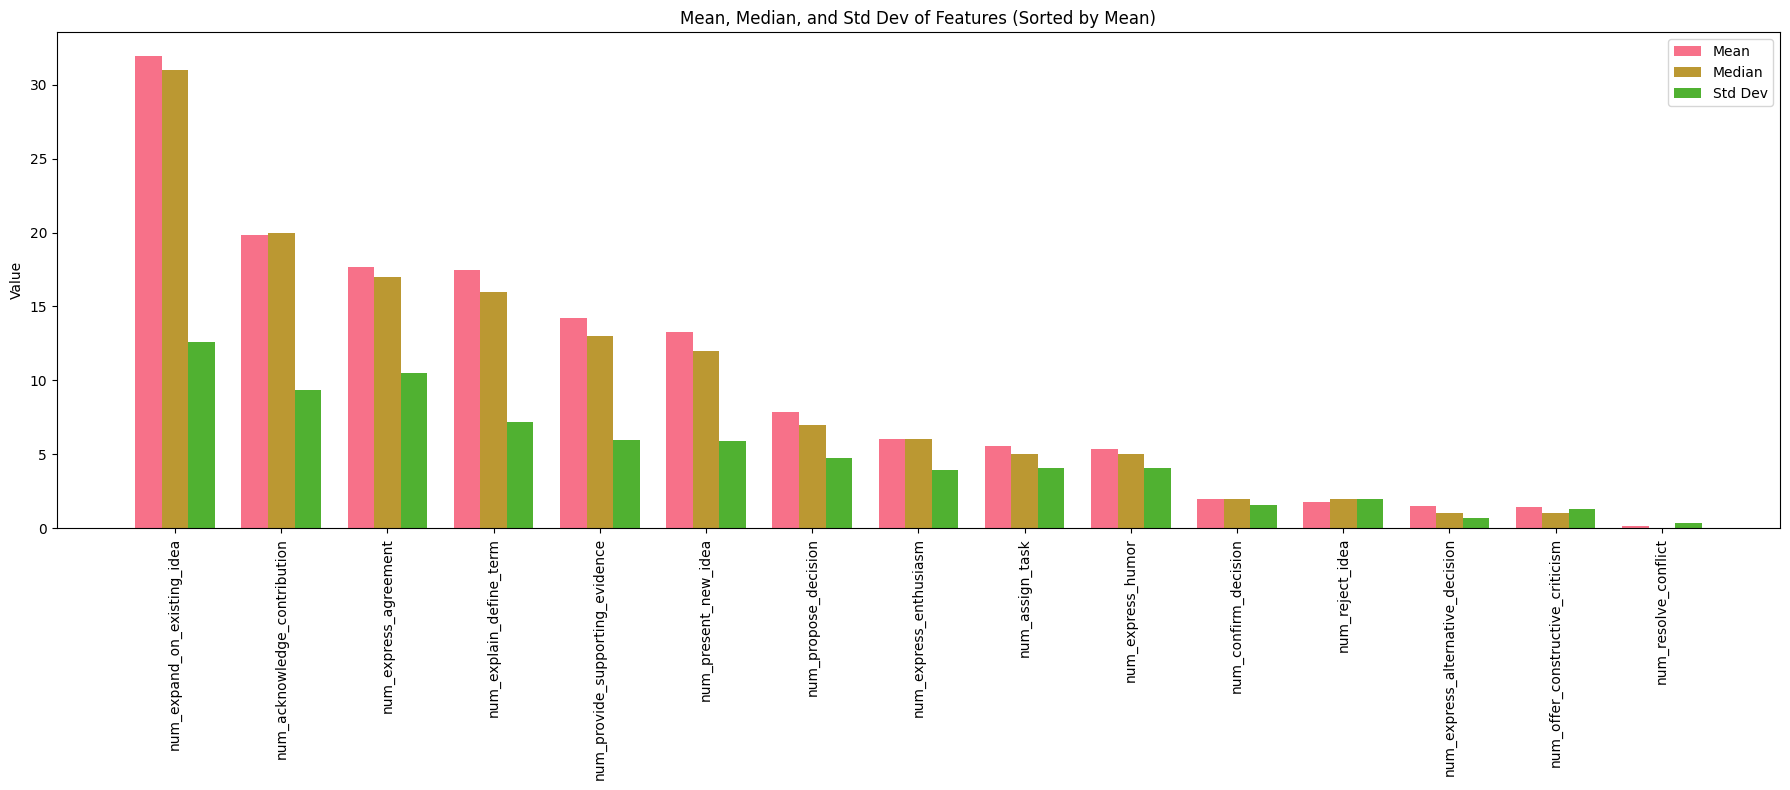

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Columns to exclude
exclude = ['conference', 'session', 'num_teams', 'num_funded_teams']

# Select feature columns
feature_cols = [col for col in all_data_df.columns if col not in exclude]

# Calculate statistics
means = all_data_df[feature_cols].mean()
medians = all_data_df[feature_cols].median()
stds = all_data_df[feature_cols].std()

# Sort features by mean (descending)
sorted_idx = means.sort_values(ascending=False).index
means_sorted = means[sorted_idx]
medians_sorted = medians[sorted_idx]
stds_sorted = stds[sorted_idx]

x = np.arange(len(feature_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, means_sorted, width, label='Mean')
ax.bar(x, medians_sorted, width, label='Median')
ax.bar(x + width, stds_sorted, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(sorted_idx, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (Sorted by Mean)')
ax.legend()
plt.tight_layout()
plt.show()

In [37]:
## NORMALIZE features

from sklearn.preprocessing import StandardScaler

# Columns to exclude from normalization
exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams']

# Columns to normalize
normalize_columns = [col for col in all_data_df.columns if col not in exclude_columns]

# Fill missing values for normalization
all_data_df_filled = all_data_df.copy()
all_data_df_filled[normalize_columns] = all_data_df_filled[normalize_columns].fillna(0)

# Normalize selected columns
scaler = StandardScaler()
normalized_values = scaler.fit_transform(all_data_df_filled[normalize_columns])

# Create normalized DataFrame
normalized_df = pd.DataFrame(normalized_values, columns=normalize_columns, index=all_data_df.index)

# Combine with excluded columns (keep original values)
for col in exclude_columns:
    normalized_df[col] = all_data_df[col]

# Reorder columns to match original DataFrame
normalized_df = normalized_df[exclude_columns + normalize_columns]

print(normalized_df.head())

  conference             session  num_teams  num_funded_teams  \
0    2021ABI   2021_05_20_ABI_S5          3                 0   
1    2021ABI   2021_05_20_ABI_S4          2                 2   
2    2021ABI  2021_05_21_ABI_S16          0                 0   
3    2021ABI   2021_05_21_ABI_S1          2                 2   
4    2021ABI   2021_05_20_ABI_S8          4                 0   

   num_present_new_idea  num_provide_supporting_evidence  \
0             -0.212800                         1.452504   
1             -0.212800                        -1.202267   
2             -0.382632                        -0.577615   
3              0.636355                        -0.889941   
4             -0.892125                         1.296341   

   num_propose_decision  num_expand_on_existing_idea  num_express_agreement  \
0              0.236577                     0.811756               0.993021   
1             -0.617156                    -1.063960              -0.063655   
2          

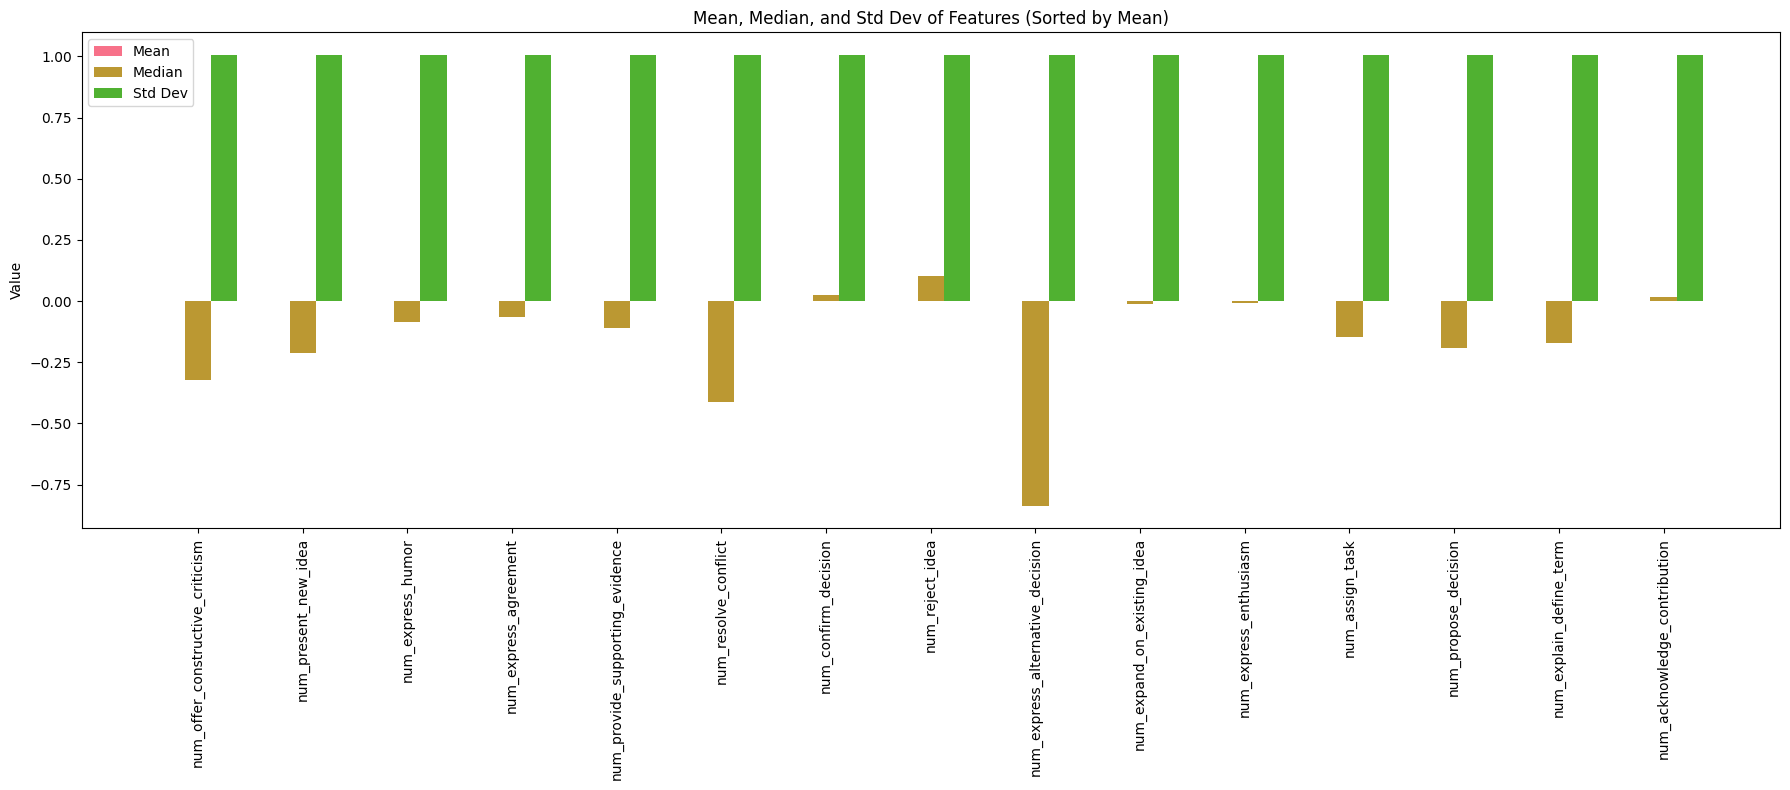

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Columns to exclude
exclude = ['conference', 'session', 'num_teams', 'num_funded_teams']

# Select feature columns
feature_cols = [col for col in normalized_df.columns if col not in exclude]

# Calculate statistics
means = normalized_df[feature_cols].mean()
medians = normalized_df[feature_cols].median()
stds = normalized_df[feature_cols].std()

# Sort features by mean (descending)
sorted_idx = means.sort_values(ascending=False).index
means_sorted = means[sorted_idx]
medians_sorted = medians[sorted_idx]
stds_sorted = stds[sorted_idx]

x = np.arange(len(feature_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, means_sorted, width, label='Mean')
ax.bar(x, medians_sorted, width, label='Median')
ax.bar(x + width, stds_sorted, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(sorted_idx, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (Sorted by Mean)')
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
normalized_df.to_excel('normalized_all_data_df.xlsx', index=False)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


def normalize_features(df):
    """
    Normalize features using StandardScaler and return both original and normalized data.
    """
    # Identify feature columns (exclude metadata columns)
    exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams', 
                      'has_teams', 'has_funded_teams']
    
    feature_columns = [col for col in df.columns if col not in exclude_columns]
    
    # Select only numeric features
    numeric_features = df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Found {len(numeric_features)} numeric features for normalization")
    
    # Handle missing values
    df_clean = df[numeric_features].fillna(0)
    
    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df_clean)
    
    # Create DataFrame with normalized features
    df_normalized = pd.DataFrame(normalized_features, 
                                columns=numeric_features, 
                                index=df.index)
    
    return df_normalized, numeric_features, scaler

### logstic regression (use normalized_df)

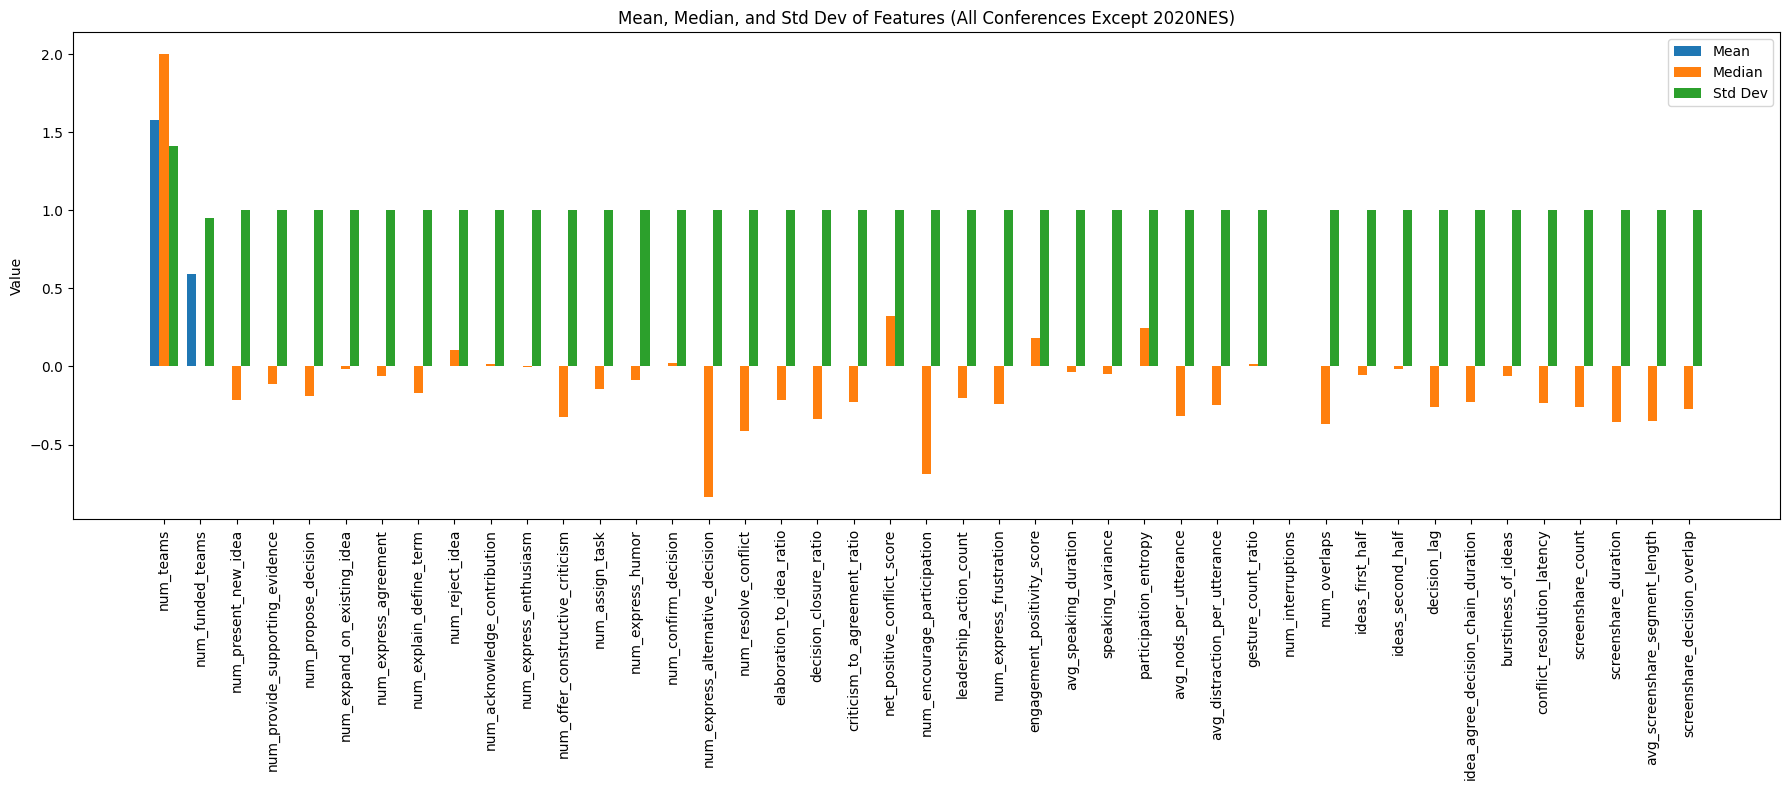

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out rows where conference == '2020NES'
filtered_df = normalized_df[normalized_df['conference'] != '2020NES']

# Exclude non-numeric columns except 'conference'
numeric_cols = filtered_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate mean, median, std for each column (across all data)
mean_vals = filtered_df[numeric_cols].mean()
median_vals = filtered_df[numeric_cols].median()
std_vals = filtered_df[numeric_cols].std()

# Plotting
x = np.arange(len(numeric_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, mean_vals, width, label='Mean')
ax.bar(x, median_vals, width, label='Median')
ax.bar(x + width, std_vals, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (All Conferences Except 2020NES)')
ax.legend()
plt.tight_layout()
plt.show()


In [11]:
# Check your data distribution
print("Distribution of num_teams:")
print(normalized_df['num_teams'].value_counts().sort_index())

print("\nDistribution of num_funded_teams:")
print(normalized_df['num_funded_teams'].value_counts().sort_index())

Distribution of num_teams:
num_teams
0    20
1    21
2    27
3     9
4     5
9     1
Name: count, dtype: int64

Distribution of num_funded_teams:
num_funded_teams
0    50
1    22
2     9
3     1
6     1
Name: count, dtype: int64


In [ ]:
# Create binary versions
normalized_df = pd.read_excel('normalized_all_data_df.xlsx')
normalized_df['has_teams'] = (normalized_df['num_teams'] > 0).astype(int)
normalized_df['has_funded_teams'] = (normalized_df['num_funded_teams'] > 0).astype(int)

print("Binary target distributions:")
print("has_teams:")
print(normalized_df['has_teams'].value_counts().sort_index())
print("\nhas_funded_teams:")
print(normalized_df['has_funded_teams'].value_counts().sort_index())

Binary target distributions:
has_teams:
has_teams
0    20
1    63
Name: count, dtype: int64

has_funded_teams:
has_funded_teams
0    50
1    33
Name: count, dtype: int64


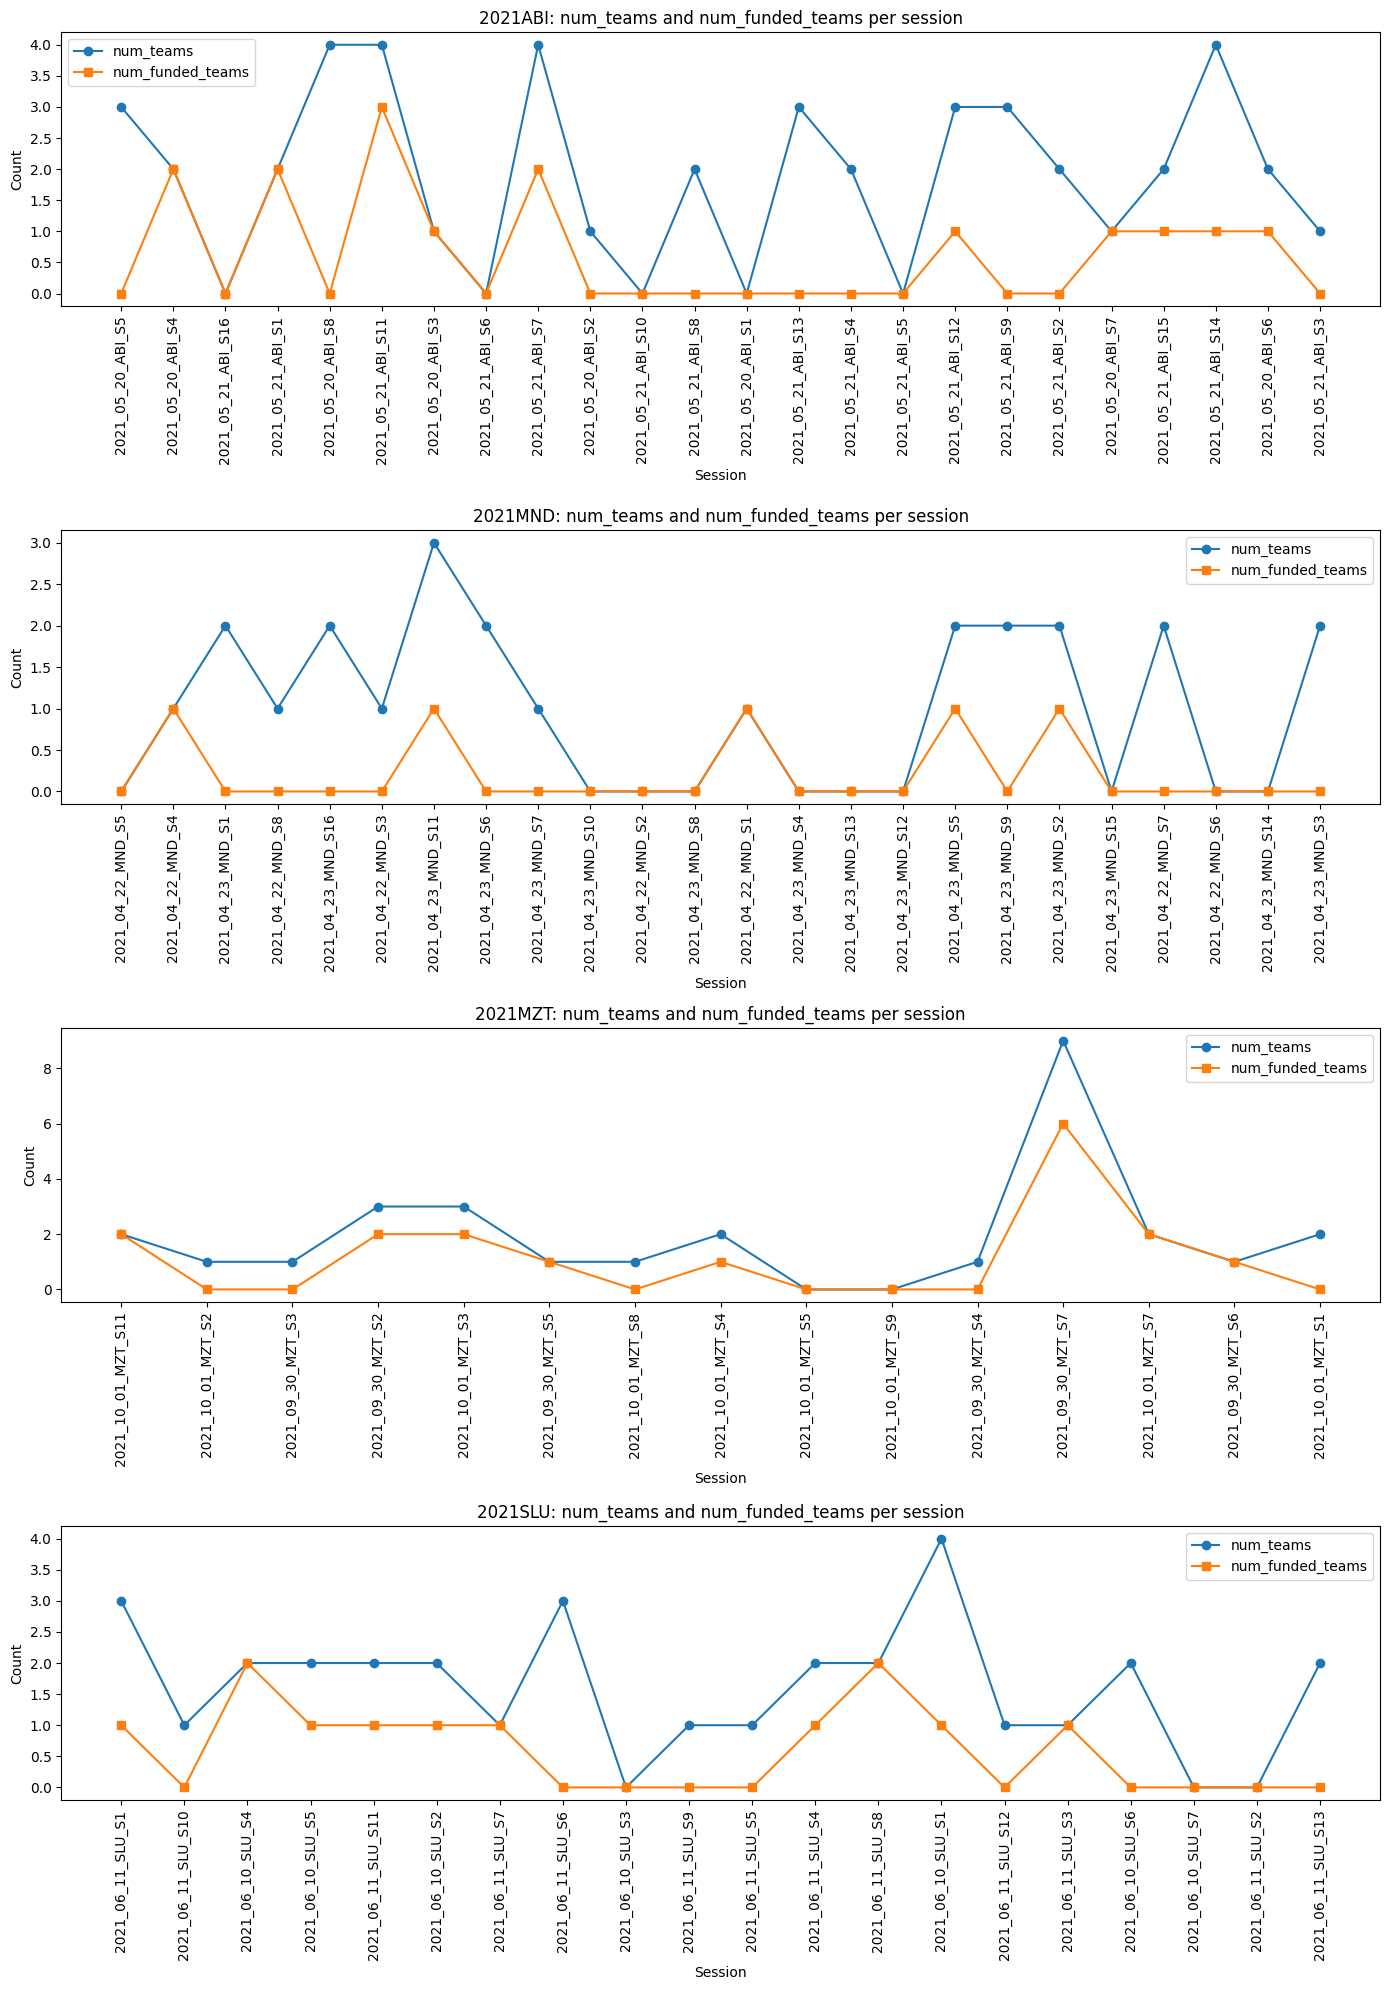

In [ ]:
import matplotlib.pyplot as plt

# Get unique conferences
unique_conferences = normalized_df['conference'].unique()

fig, axes = plt.subplots(len(unique_conferences), 1, figsize=(14, 5 * len(unique_conferences)), sharex=False)

if len(unique_conferences) == 1:
    axes = [axes]  # Ensure axes is always iterable

for idx, conf in enumerate(unique_conferences):
    conf_df = normalized_df[normalized_df['conference'] == conf]
    sessions = conf_df['session']
    num_teams = conf_df['num_teams']
    num_funded_teams = conf_df['num_funded_teams']

    ax = axes[idx]
    ax.plot(sessions, num_teams, marker='o', label='num_teams')
    ax.plot(sessions, num_funded_teams, marker='s', label='num_funded_teams')
    ax.set_title(f"{conf}: num_teams and num_funded_teams per session")
    ax.set_xlabel("Session")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels(sessions, rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Columns to exclude from multicollinearity analysis
exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']

# Select only feature columns
feature_columns = [col for col in normalized_df.columns if col not in exclude_columns]

# Compute correlation matrix
corr_matrix = normalized_df[feature_columns].corr()

# Find pairs with high absolute correlation (> 0.8)
high_corr_pairs = []
threshold = 0.8
for i in range(len(feature_columns)):
    for j in range(i+1, len(feature_columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append((feature_columns[i], feature_columns[j], corr_val))

print("Highly correlated feature pairs (|correlation| > 0.8):")
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} <-> {f2}: correlation = {corr_val:.3f}")

# Calculate Variance Inflation Factor (VIF)

X = normalized_df[feature_columns].values
vif_data = pd.DataFrame({
    'feature': feature_columns,
    'VIF': [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

print("\nVariance Inflation Factor (VIF) for each feature:")
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

# Report features with VIF > 5 (commonly considered problematic)
problematic_vif = vif_data[vif_data['VIF'] > 5]
if not problematic_vif.empty:
    print("\nFeatures with VIF > 5 (potential multicollinearity):")
    print(problematic_vif.sort_values('VIF', ascending=False).to_string(index=False))
else:
    print("\nNo features with VIF > 5 detected.")

Highly correlated feature pairs (|correlation| > 0.8):

Variance Inflation Factor (VIF) for each feature:
                         feature      VIF
     num_expand_on_existing_idea 3.259028
            num_present_new_idea 2.800422
 num_provide_supporting_evidence 2.485452
         num_explain_define_term 2.331766
    num_acknowledge_contribution 2.250718
           num_express_agreement 2.172097
          num_express_enthusiasm 1.999642
               num_express_humor 1.921397
            num_propose_decision 1.845997
                 num_assign_task 1.539053
            num_confirm_decision 1.446747
                 num_reject_idea 1.402784
num_offer_constructive_criticism 1.340146
            num_resolve_conflict 1.178157
num_express_alternative_decision 1.145778

No features with VIF > 5 detected.


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def normalize_and_run_logistic_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Normalize features and run logistic regression.
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    # Handle missing values
    X = X.fillna(0)
    
    # Split the data WITHOUT stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state  # Removed stratify=y
    )
    
    # Rest of the function remains the same...
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
    
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    
    print(f"Logistic Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance, X_train_scaled_df, X_test_scaled_df
# Usage example:
# model, scaler, importance, X_train_scaled, X_test_scaled = normalize_and_run_logistic_regression(all_data, 'num_funded_teams')

In [18]:
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

def run_logistic_regression_with_stats_robust(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run logistic regression with robust handling of multicollinearity and perfect separation.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Remove low variance features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var_selected = variance_selector.fit_transform(X_train)
    X_test_var_selected = variance_selector.transform(X_test)
    
    # Get selected feature names
    selected_features = [feature_columns[i] for i in range(len(feature_columns)) 
                        if variance_selector.get_support()[i]]
    
    print(f"Original features: {len(feature_columns)}")
    print(f"Features after variance threshold: {len(selected_features)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_var_selected)
    X_test_scaled = scaler.transform(X_test_var_selected)
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train_scaled)
    X_test_with_const = sm.add_constant(X_test_scaled)
    
    # Try different fitting methods
    methods_to_try = ['newton', 'bfgs', 'lbfgs', 'powell', 'cg']
    results = None
    
    for method in methods_to_try:
        try:
            print(f"Trying method: {method}")
            model = sm.Logit(y_train, X_train_with_const)
            results = model.fit(method=method, maxiter=1000, disp=0)
            print(f"Success with method: {method}")
            break
        except Exception as e:
            print(f"Method {method} failed: {str(e)[:100]}...")
            continue
    
    if results is None:
        print("All methods failed. Trying with regularization...")
        # Use sklearn with regularization as fallback
        from sklearn.linear_model import LogisticRegression
        sklearn_model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=random_state)
        sklearn_model.fit(X_train_scaled, y_train)
        
        # Create a mock results object for reporting
        class MockResults:
            def __init__(self, model, feature_names):
                self.params = np.concatenate([[0], model.coef_[0]])  # Add intercept
                self.pvalues = np.ones(len(self.params))  # Placeholder p-values
                self.bse = np.ones(len(self.params)) * 0.1  # Placeholder std errors
                self.tvalues = self.params / self.bse
                self.summary = lambda: print("Using sklearn with L2 regularization (no p-values available)")
        
        results = MockResults(sklearn_model, selected_features)
        y_pred_proba = sklearn_model.predict_proba(X_test_scaled)[:, 1]
        y_pred = sklearn_model.predict(X_test_scaled)
    else:
        # Get predictions for sklearn metrics
        y_pred_proba = results.predict(X_test_with_const)
        y_pred = (y_pred_proba > 0.5).astype(int)
    
    print(f"\nLogistic Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"Accuracy: {(y_pred == y_test).mean():.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    try:
        print(results.summary())
    except:
        print("Summary not available (using sklearn fallback)")
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + selected_features
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    z_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        'z_score': z_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    if len(significant_features) > 0:
        print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    else:
        print("No features significant at p < 0.05")
    
    return results, results_df, scaler, selected_features

In [26]:
def visualize_logistic_features(df, target_column, top_n=10, save_plots=False):
    """
    Create comprehensive visualizations of logistic regression feature importance.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Your dataset
    target_column : str
        Name of the target variable
    top_n : int
        Number of top features to show in plots
    save_plots : bool
        Whether to save plots to files
    """
    
    print(f"Running logistic regression for target: {target_column}")
    print("=" * 60)
    
    # Run logistic regression
    results, coef_df, scaler, selected_features = run_logistic_regression_with_stats_robust(df, target_column)
    
    # Remove intercept for visualization
    feature_df = coef_df[coef_df['feature'] != 'intercept'].copy()
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Coefficient Magnitude Plot (Top N features)
    plt.subplot(2, 3, 1)
    top_features = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    bars = plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Most Predictive Features\n(Red=Negative, Blue=Positive)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add coefficient values on bars
    for i, (bar, coef) in enumerate(zip(bars, top_features['coefficient'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{coef:.3f}', va='center', fontsize=9)
    
    # 2. Coefficient Direction Plot
    plt.subplot(2, 3, 2)
    top_features_signed = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features_signed['coefficient']]
    bars = plt.barh(range(len(top_features_signed)), top_features_signed['coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features_signed)), top_features_signed['feature'], fontsize=10)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Feature Effects on {target_column}\n(Red=Decreases, Blue=Increases)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)
    
    # 3. Statistical Significance Plot (if available)
    plt.subplot(2, 3, 3)
    if not feature_df['p_value'].isna().all():
        significant_features = feature_df[feature_df['p_value'] < 0.05].nlargest(top_n, 'abs_coefficient')
        if len(significant_features) > 0:
            colors = ['red' if x < 0 else 'blue' for x in significant_features['coefficient']]
            bars = plt.barh(range(len(significant_features)), significant_features['abs_coefficient'], color=colors, alpha=0.7)
            
            plt.yticks(range(len(significant_features)), significant_features['feature'], fontsize=10)
            plt.xlabel('Absolute Coefficient Value', fontsize=12)
            plt.title(f'Statistically Significant Features\n(p < 0.05)', fontsize=14, fontweight='bold')
            plt.grid(axis='x', alpha=0.3)
            
            # Add p-values on bars
            for i, (bar, p_val) in enumerate(zip(bars, significant_features['p_value'])):
                plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'p={p_val:.3f}', va='center', fontsize=9)
        else:
            plt.text(0.5, 0.5, 'No significant features\n(p < 0.05)', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=14)
            plt.title('Statistically Significant Features', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Statistical Significance', fontsize=14, fontweight='bold')
    
    # 4. Coefficient vs P-value Scatter Plot (if available)
    plt.subplot(2, 3, 4)
    if not feature_df['p_value'].isna().all():
        plt.scatter(feature_df['coefficient'], -np.log10(feature_df['p_value']), alpha=0.6, s=50)
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.ylabel('-log10(p-value)', fontsize=12)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
        plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Label top features
        top_features_scatter = feature_df.nlargest(5, 'abs_coefficient')
        for _, row in top_features_scatter.iterrows():
            plt.annotate(row['feature'], (row['coefficient'], -np.log10(row['p_value'])), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
    

    
    # 5. Coefficient Distribution
    plt.subplot(2, 3, 5)
    plt.hist(feature_df['coefficient'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Feature Coefficients', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero effect')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'logistic_regression_features_{target_column}.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: logistic_regression_features_{target_column}.png")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS:")
    print("=" * 60)
    print(f"Total features analyzed: {len(feature_df)}")
    print(f"Positive coefficients: {len(feature_df[feature_df['coefficient'] > 0])}")
    print(f"Negative coefficients: {len(feature_df[feature_df['coefficient'] < 0])}")
    
    if not feature_df['p_value'].isna().all():
        significant_count = len(feature_df[feature_df['p_value'] < 0.05])
        print(f"Statistically significant (p < 0.05): {significant_count}")
        print(f"Highly significant (p < 0.01): {len(feature_df[feature_df['p_value'] < 0.01])}")
    
    print(f"Mean absolute coefficient: {feature_df['abs_coefficient'].mean():.4f}")
    print(f"Max absolute coefficient: {feature_df['abs_coefficient'].max():.4f}")
    
    return results, coef_df, scaler, selected_features

Running logistic regression for target: has_teams
Original features: 15
Features after variance threshold: 15
Trying method: newton
Success with method: newton

Logistic Regression Results for has_teams
Training samples: 66
Test samples: 17
ROC AUC: 0.467
Accuracy: 0.471

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:              has_teams   No. Observations:                   66
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           15
Date:                Mon, 04 Aug 2025   Pseudo R-squ.:                  0.4616
Time:                        13:44:36   Log-Likelihood:                -19.045
converged:                       True   LL-Null:                       -35.373
Covariance Type:            nonrobust   LLR p-value:                  0.005234
                 coef    std err          z      P>|z|      [0.025      0.

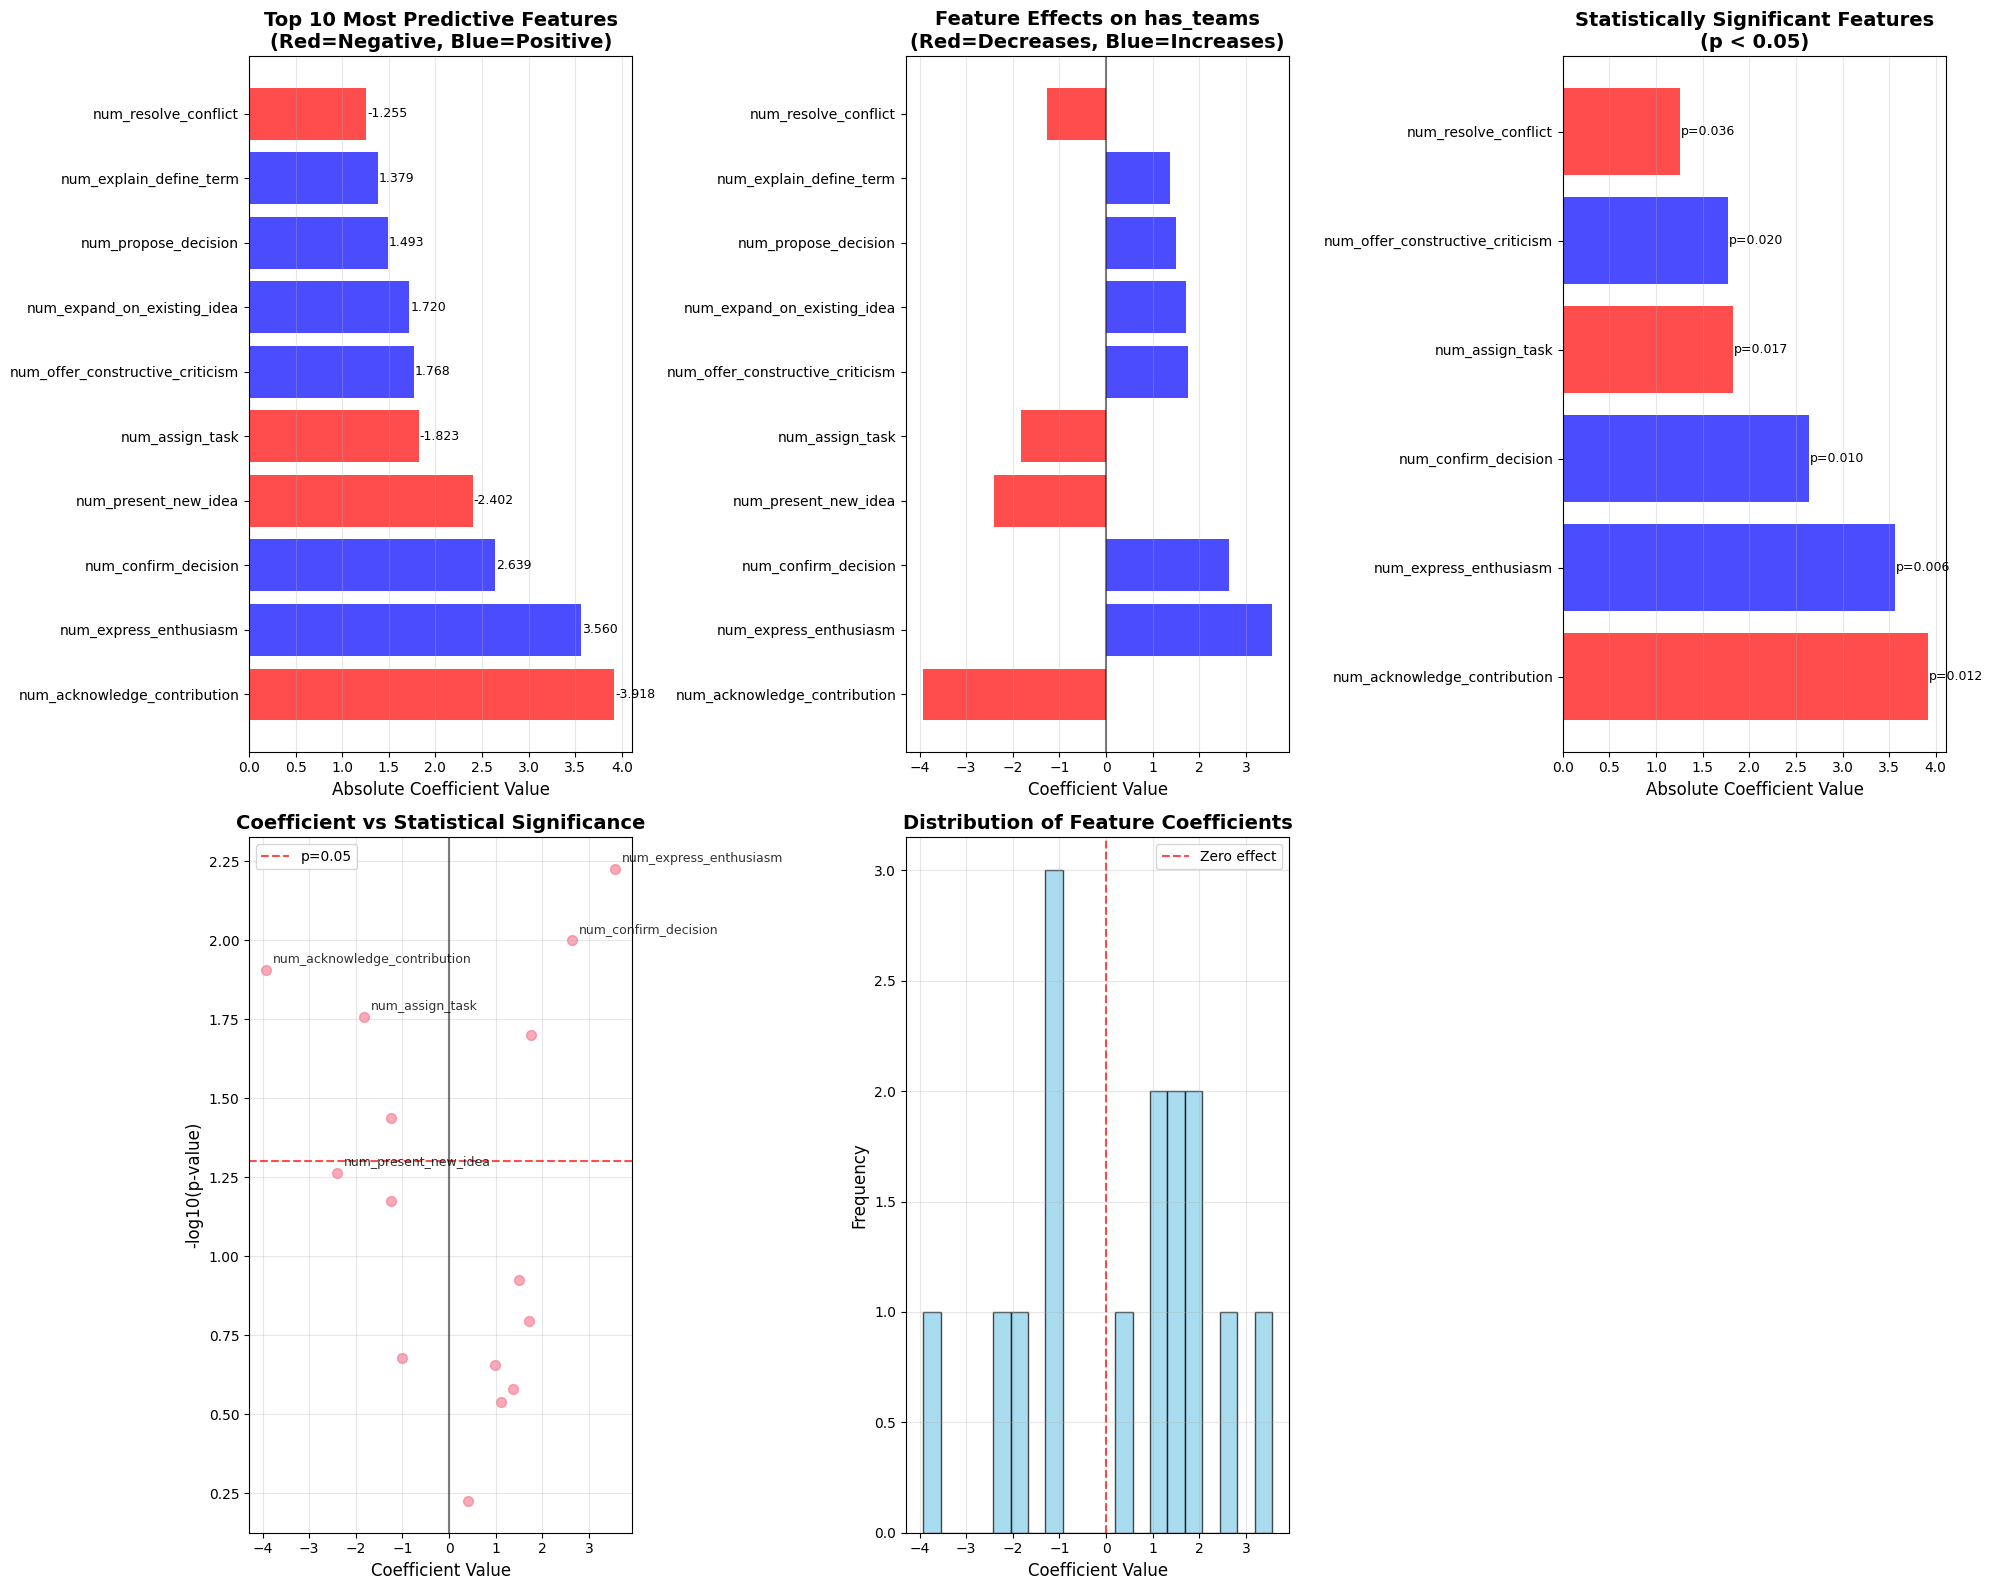


SUMMARY STATISTICS:
Total features analyzed: 15
Positive coefficients: 9
Negative coefficients: 6
Statistically significant (p < 0.05): 6
Highly significant (p < 0.01): 2
Mean absolute coefficient: 1.7800
Max absolute coefficient: 3.9180


In [27]:
df = normalized_df
target = 'has_teams'  # Change this to your target variable
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

Running logistic regression for target: has_funded_teams
Original features: 15
Features after variance threshold: 15
Trying method: newton
Success with method: newton

Logistic Regression Results for has_funded_teams
Training samples: 66
Test samples: 17
ROC AUC: 0.350
Accuracy: 0.471

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:       has_funded_teams   No. Observations:                   66
Model:                          Logit   Df Residuals:                       50
Method:                           MLE   Df Model:                           15
Date:                Mon, 04 Aug 2025   Pseudo R-squ.:                  0.2844
Time:                        13:47:59   Log-Likelihood:                -32.193
converged:                       True   LL-Null:                       -44.987
Covariance Type:            nonrobust   LLR p-value:                   0.04257
                 coef    std err          z      P>|z|      

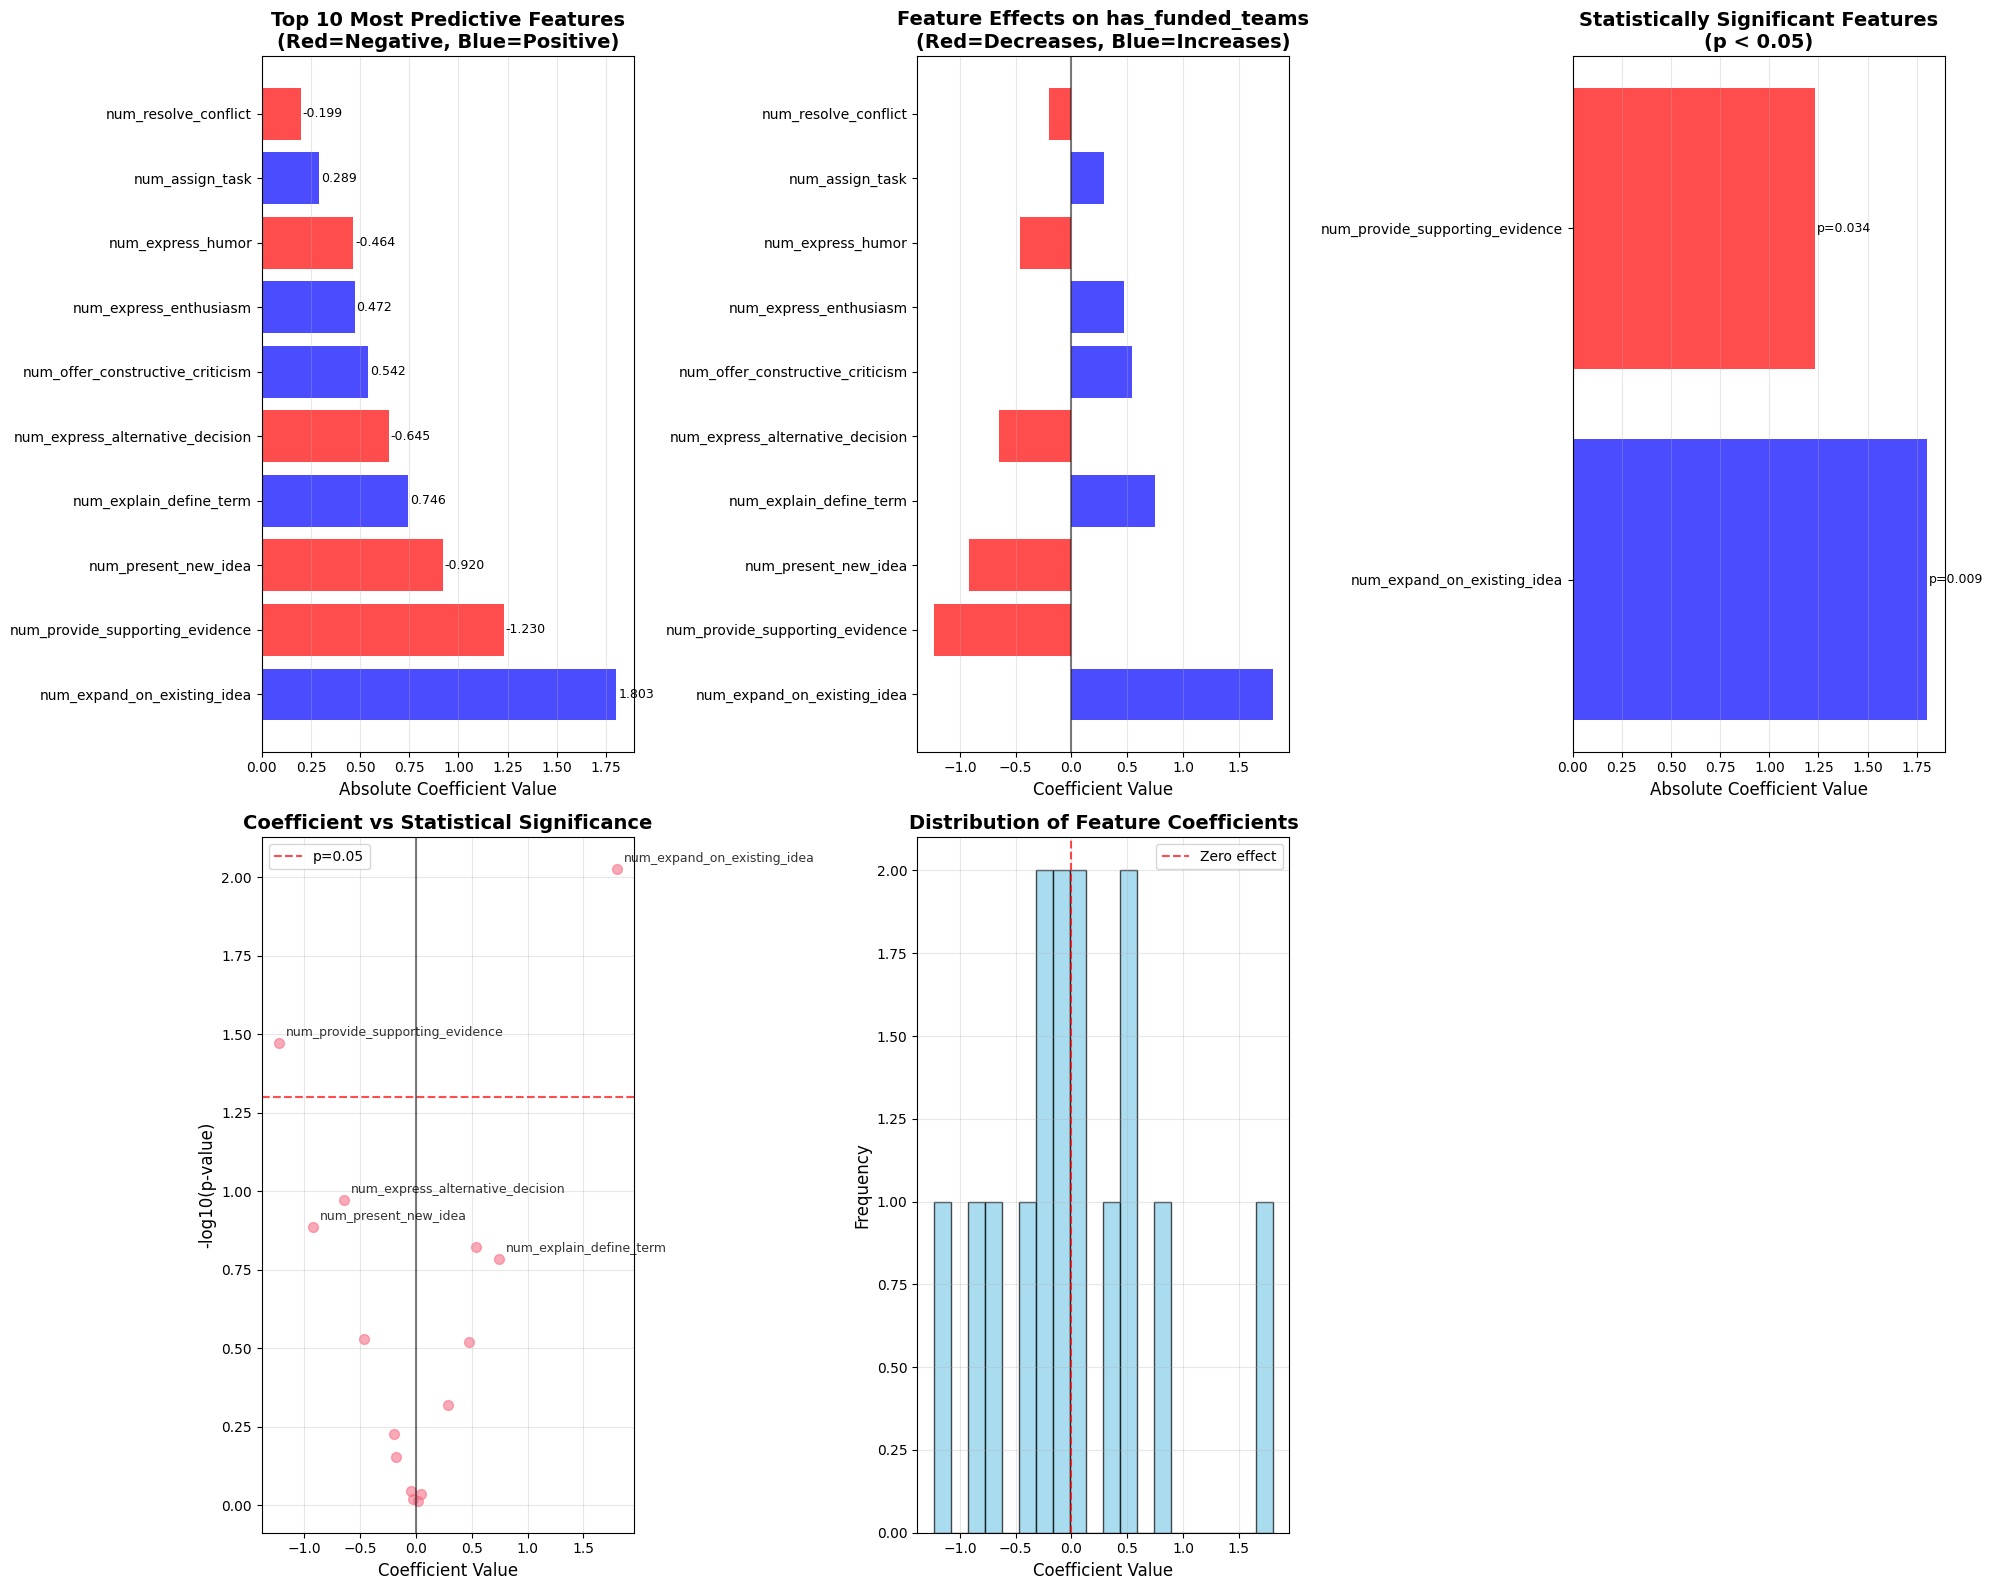


SUMMARY STATISTICS:
Total features analyzed: 15
Positive coefficients: 7
Negative coefficients: 8
Statistically significant (p < 0.05): 2
Highly significant (p < 0.01): 1
Mean absolute coefficient: 0.5080
Max absolute coefficient: 1.8032


In [28]:
df = normalized_df
target = 'has_funded_teams'  # Change this to your target variable
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

### Linear regression (use all_data_df)

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import statsmodels.api as sm
from scipy import stats
import numpy as np

import statsmodels.api as sm
from scipy import stats
import numpy as np


def run_linear_regression_with_stats(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run linear regression with statistical significance testing using statsmodels.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test)
    
    # Fit linear regression with statsmodels
    model = sm.OLS(y_train, X_train_with_const)
    results = model.fit()
    
    # Get predictions
    y_pred = results.predict(X_test_with_const)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Adjusted R²: {results.rsquared_adj:.3f}")
    print(f"F-statistic: {results.fvalue:.3f}")
    print(f"F-statistic p-value: {results.f_pvalue:.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    print(results.summary())
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + feature_columns
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    t_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        't_score': t_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    
    return results, results_df, scaler

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def run_linear_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """Run linear regression for continuous targets."""
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    
    X_train_scaled_df = pd.DataFrame(X_train, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test, columns=feature_columns, index=X_test.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_,
        'abs_coefficient': np.abs(model.coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance



In [42]:
# Run linear regression
print("Predicting num_teams (regression):")
model1, scaler1, importance1 = run_linear_regression_with_stats(all_data_df, 'num_teams')

print("\nPredicting num_funded_teams (regression):")
model2, scaler2, importance2 = run_linear_regression_with_stats(all_data_df, 'num_funded_teams')

Predicting num_teams (regression):
Linear Regression Results for num_teams
Training samples: 66
Test samples: 17
R² Score: -0.335
Adjusted R²: 0.057
F-statistic: 1.264
F-statistic p-value: 0.260

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:              num_teams   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.264
Date:                Mon, 04 Aug 2025   Prob (F-statistic):              0.260
Time:                        14:38:38   Log-Likelihood:                -107.37
No. Observations:                  66   AIC:                             246.7
Df Residuals:                      50   BIC:                             281.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                   